# [Original Paper](https://arxiv.org/pdf/1903.06836.pdf)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import torch
import torchvision
import cv2
from skimage.feature import greycomatrix

In [3]:
from torchvision.models import resnet50 
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [6]:
import os
from tqdm import tqdm
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset

In [7]:
torch.cuda.empty_cache()

In [8]:
torch.cuda.get_device_name()

'Tesla V100-SXM2-16GB'

# Transform

In [9]:
def CO_Matrix(image):
    
    distance_offset = [1]
    angle_offset = [0] 
    
    Co_Occurence_Matrix = np.zeros((3,256,256)) 

    image = np.array(image)
    
    for z in range(Co_Occurence_Matrix.shape[0]):
        co_all = greycomatrix(image[:,:,z], distance_offset, angle_offset, levels=256) 
        
        
        Co_Occurence_Matrix[z,:,:] = co_all[:,:,0,0] 
    
    
    matrix = torch.from_numpy(Co_Occurence_Matrix) 
    
    return matrix 

# Dataset, Dataloader

In [10]:
valid_size = .005
batch_size = 64 
num_workers = 2
classes = ["Real", "Fake"]

In [11]:
categories = os.listdir("./progan_train")
print(categories)

start_time_train = time.time()

train_datasets = []
print("Loading Training Data...", flush=True)
for category in tqdm(categories):
    train_datasets.append(datasets.ImageFolder("./progan_train/" + category, transform=CO_Matrix))
    
train_dataset = torch.utils.data.ConcatDataset(train_datasets)

print("Load Time-",round(time.time()-start_time_train,4),"secs")
print("No of images in train dataset=",len(train_dataset))

['diningtable', 'car', 'sofa', 'boat', 'motorbike', 'airplane', 'horse', 'chair', 'tvmonitor', 'bottle', 'cat', 'train', 'person', 'pottedplant', 'bicycle', 'dog', 'sheep', 'bird', 'bus', 'cow']
Loading Training Data...


100%|██████████| 20/20 [08:53<00:00, 26.69s/it]

Load Time- 533.8733 secs
No of images in train dataset= 720119


In [12]:
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

class_names = train_datasets[0].classes

print("Training Dataloader Length=",len(train_loader))
print("Validation Dataloader Length=",len(valid_loader))

Training Dataloader Length= 11196
Validation Dataloader Length= 57


# Training, Validation, Testing Loop

In [14]:
def validation_loop(device, model, dataloader): 
    
    model=model.eval()
    
    accuracy = 0
    no_of_batches = len(dataloader)
    
    with torch.no_grad():
        for d in dataloader:
            images, labels = d

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            outputs = outputs[:,0]

            correct = ((outputs>=0.5).float() == labels.float())
            acc=torch.sum(correct)/float(len(labels))
            accuracy+=acc.item()
                
    return round(100*accuracy/no_of_batches,4)

In [15]:
def train_loop(device, model, dataloader, val_loader, optimizer, criterion):
    
    start = time.time()
    
    accuracy = 0
    no_of_batches = len(dataloader)
    losses = 0
    model = model.train()
    
    i = 0
    
    train_acc_list=[]
    train_loss_list=[]
    val_acc_list=[]
    
    for d in dataloader:
        images, labels = d
                
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        outputs = outputs[:,0]
        
        loss = criterion(outputs.float(),labels.float())
        
        loss.backward()
        optimizer.step()
        
        correct = ((outputs>=0.5).float() == labels.float())
        acc=torch.sum(correct)/float(len(labels))
                
        accuracy+=acc.item()
        
        losses+=loss.item()
        
        i+=1
        
        if(i%2500==0):
            
            val_acc = validation_loop(device, model, val_loader)
            train_acc = round(100*accuracy/i,4)
            train_loss = round(losses/i,4)
            
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
            val_acc_list.append(val_acc)
            
            model = model.train()
            
            print("[",i,"/",no_of_batches,"]---Train Accuracy=",train_acc,"Validation Accuracy=",val_acc,"Train Loss=",train_loss)
            print("Time taken=",round((time.time()-start)/60.0,4),"min")
            print("") 

    
    train_acc=round(100*accuracy/no_of_batches,4)
    train_loss=round(losses/no_of_batches,4)
    val_acc = validation_loop(device, model, val_loader)
    
    print("Final train accuracy=",train_acc,"%")
    print("Final train loss=",train_loss)
    print("Final validation accuracy=",val_acc,"%")
    
    print("Training Time taken=",round((time.time()-start)/60.0,4),"min")
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    
    return train_acc_list,train_loss_list,val_acc_list, train_loss, val_acc

# Co-NET Model

In [16]:
class Co_NET(torch.nn.Module):
    def __init__(self):
        super(Co_NET, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 32, (3,3))
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(32, 32, (5,5))
        self.pool1 = torch.nn.MaxPool2d((3,3),stride=3)
        
        self.conv3 = torch.nn.Conv2d(32, 64, (3,3))
        self.relu2 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(64, 64, (5,5))
        self.pool2 = torch.nn.MaxPool2d((3,3),stride=3)
        
        self.conv5 = torch.nn.Conv2d(64, 128, (3,3))
        self.relu3 = torch.nn.ReLU()
        self.conv6 = torch.nn.Conv2d(128, 128, (5,5))
        self.pool3 = torch.nn.MaxPool2d((3,3),stride=3)
         
        self.dense1 = torch.nn.Linear(128 * 6 * 6, 256)
        self.dense2 = torch.nn.Linear(256,1)
        self.sigmoid1 = torch.nn.Sigmoid()
        

    def forward(self, x):
        
        x2 = self.conv1(x)
        x2 = self.relu1(x2)
        x3 = self.conv2(x2)
        x4 = self.pool1(x3)
        
        x5 = self.conv3(x4)
        x5 = self.relu2(x5)
        x6 = self.conv4(x5)
        x7 = self.pool2(x6)
        
        x8 = self.conv5(x7)
        x8 = self.relu3(x8)
        x9 = self.conv6(x8)
        x10 = self.pool3(x9)
        
        x10 = x10.view(-1, 128 * 6 * 6) 
        x11 = self.dense1(x10)
        x12 = self.dense2(x11)
        x13 = self.sigmoid1(x12)

        return x13

In [17]:
co_net_model_trial = Co_NET()
co_net_model_trial = co_net_model_trial.double()
co_net_model_trial

Co_NET(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=4608, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid1): Sigmoid()
)

In [18]:
inputs, classes = next(iter(train_loader))

print(inputs.shape)
print(inputs[0].shape)
print("")

outputs = co_net_model_trial(inputs)
outputs = outputs[:,0]
print(outputs)
print(classes)

correct = ((outputs>=0.5).float() == classes.float())
acc=torch.sum(correct)/float(len(classes))
print(acc)

torch.Size([64, 3, 256, 256])
torch.Size([3, 256, 256])

tensor([0.5337, 0.5216, 0.5152, 0.5171, 0.5080, 0.5128, 0.5234, 0.5133, 0.5093,
        0.5151, 0.5151, 0.5241, 0.5232, 0.6024, 0.5167, 0.5152, 0.5099, 0.5397,
        0.5365, 0.5333, 0.5149, 0.5338, 0.5251, 0.5593, 0.5354, 0.5211, 0.5148,
        0.5166, 0.5136, 0.5486, 0.5170, 0.5175, 0.5146, 0.6169, 0.5377, 0.5118,
        0.5179, 0.5091, 0.5096, 0.5520, 0.5138, 0.5113, 0.5329, 0.5189, 0.5094,
        0.5175, 0.5204, 0.5106, 0.5822, 0.5188, 0.5287, 0.5077, 0.5109, 0.5297,
        0.5272, 0.5216, 0.5332, 0.5146, 0.5119, 0.5309, 0.5145, 0.5153, 0.5473,
        0.5525], dtype=torch.float64, grad_fn=<SelectBackward>)
tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1])
tensor(0.5000)


In [19]:
co_net_model = Co_NET()
co_net_model = co_net_model.double()
co_net_model

Co_NET(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=4608, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid1): Sigmoid()
)

In [20]:
learning_rate = 1e-6 
optimizer = torch.optim.Adam(co_net_model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = torch.nn.BCELoss().to(device)
co_net_model = co_net_model.to(device)

# Training the model

In [21]:
total_start = time.time()
epochs = 5 

train_loss_list_epochs = []
val_acc_list_epochs = []

val_acc_list = []
train_loss_list = []
train_acc_list = []

for i in range(epochs):
    print("================================================Epoch ",i+1,"==================================================")
    
    a,b,c,train_loss,val_acc = train_loop(device, co_net_model, train_loader, valid_loader, optimizer, criterion)
    
    train_loss_list_epochs.append(train_loss)
    val_acc_list_epochs.append(val_acc)

    val_acc_list+=c
    train_loss_list+=b
    train_acc_list+=a
    
    print("\n")
        
print("================================================End==================================================")
print("Total training time after",epochs,"epochs=",round(((time.time()-total_start)/3600.0),4),"hours")

================================================Epoch  1 ==================================================
[ 2500 / 11196 ]---Train Accuracy= 57.885 Validation Accuracy= 62.034 Train Loss= 0.6787
Time taken= 40.7891 min

[ 5000 / 11196 ]---Train Accuracy= 62.2809 Validation Accuracy= 73.1908 Train Loss= 0.6544
Time taken= 79.6616 min

[ 7500 / 11196 ]---Train Accuracy= 67.4608 Validation Accuracy= 82.5384 Train Loss= 0.608
Time taken= 117.6692 min

[ 10000 / 11196 ]---Train Accuracy= 71.6513 Validation Accuracy= 85.6634 Train Loss= 0.5572
Time taken= 155.6772 min

Final train accuracy= 73.2101 %
Final train loss= 0.5357
Final validation accuracy= 86.5132 %
Training Time taken= 173.7703 min


================================================Epoch  2 ==================================================
[ 2500 / 11196 ]---Train Accuracy= 87.3625 Validation Accuracy= 88.1579 Train Loss= 0.3248
Time taken= 31.943 min

[ 5000 / 11196 ]---Train Accuracy= 88.3137 Validation Accuracy= 90.2138 Tra

In [22]:
torch.save(co_net_model, "./Co_Net/co_net_model_trained.pt")

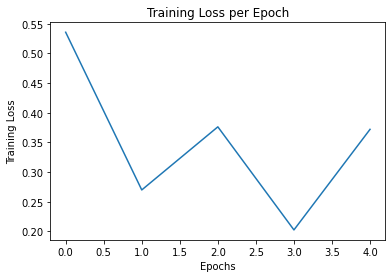

In [23]:
plt.title("Training Loss per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Training Loss') 
plt.plot(train_loss_list_epochs)
plt.show()

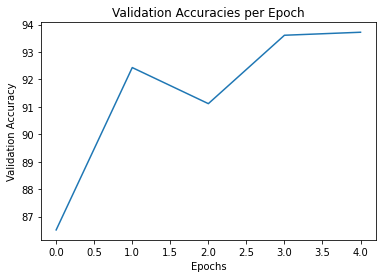

In [24]:
plt.title("Validation Accuracies per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.plot(val_acc_list_epochs)
plt.show()

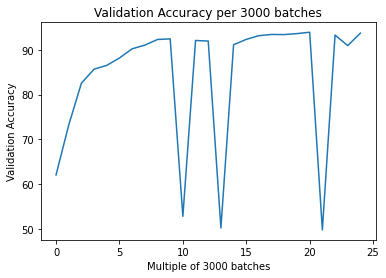

In [25]:
plt.title("Validation Accuracy per 3000 batches")
plt.xlabel('Multiple of 3000 batches')
plt.ylabel('Validation Accuracy')
plt.plot(val_acc_list)
plt.show()

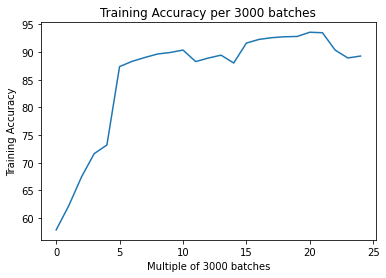

In [26]:
plt.title("Training Accuracy per 3000 batches")
plt.xlabel('Multiple of 3000 batches')
plt.ylabel('Training Accuracy')
plt.plot(train_acc_list)
plt.show()

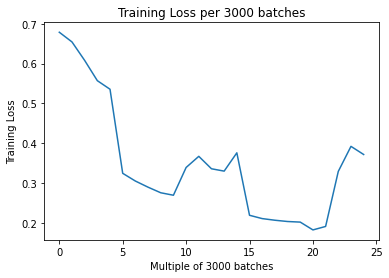

In [27]:
plt.title("Training Loss per 3000 batches")
plt.xlabel('Multiple of 3000 batches')
plt.ylabel('Training Loss')
plt.plot(train_loss_list)
plt.show()

# Testing

In [28]:
def report(preds, labels):
    
    
    cr = classification_report(y_true=labels, y_pred=preds, labels=[0, 1], output_dict=True)
    
    
    acc = round(cr['accuracy'],4)
    prec_0 = round(cr['0']['precision'],4)
    rec_0 = round(cr['0']['recall'],4)
    f1_0 = round(cr['0']['f1-score'],4)
    prec_1 = round(cr['1']['precision'],4)
    rec_1 = round(cr['1']['recall'],4)
    f1_1 = round(cr['1']['f1-score'],4)
    
    return acc, rec_0, rec_1, prec_0, prec_1, f1_0, f1_1

In [29]:
def test_loop(device, model, dataloader): 
    
    model=model.eval()
    
    predictions_list = []
    labels_list = []
    
    with torch.no_grad():
        for d in dataloader:
            images, labels = d

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            outputs = outputs[:,0]
            
            preds = (outputs>=0.5).float()
            
            predictions_list+=preds.tolist()
            labels_list+=labels.tolist()
            
                
    return predictions_list, labels_list 

In [30]:
test_start = time.time()
gans = os.listdir("./CNN_synth_testset")

test_accs = []
test_recall_1 = []
test_recall_0 = []
test_precision_1 = []
test_precision_0 = []
test_f1_1 = []
test_f1_0 = []

for gan in gans:
    subdirs = os.listdir("./CNN_synth_testset/" + gan)
    if len(subdirs) == 2:
        gan_dataset = datasets.ImageFolder("./CNN_synth_testset/" + gan, transform=CO_Matrix) 
    else:
        gan_datasets = [datasets.ImageFolder("./CNN_synth_testset/" + gan + "/" + cat, transform=CO_Matrix) for cat in subdirs]
        gan_dataset = torch.utils.data.ConcatDataset(gan_datasets)
        
    gan_loader = torch.utils.data.DataLoader(gan_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    preds, labels = test_loop(device, co_net_model, gan_loader)
        
    acc, rec_0, rec_1, prec_0, prec_1, f1_0, f1_1 = report(preds, labels)
    
    print("\n--------",gan," DATASET------\n")
    
    print("Overall Accuracy-",acc)
    print("------(Real)------")
    print("Precision-",prec_0)
    print("Recall-",rec_0)
    print("F1 Score-",f1_0)
    print("------(Fake)------")
    print("Precision-",prec_1)
    print("Recall-",rec_1)
    print("F1 Score-",f1_1)
    
    test_accs.append(acc) 

print(" ")
print("Testing Time=",round((time.time()-test_start)/60.0,4)," minutes")


-------- imle  DATASET------

Overall Accuracy- 0.6377
------(Real)------
Precision- 0.99
Recall- 0.2783
F1 Score- 0.4344
------(Fake)------
Precision- 0.5801
Recall- 0.9972
F1 Score- 0.7335

-------- stylegan  DATASET------

Overall Accuracy- 0.9391
------(Real)------
Precision- 0.9845
Recall- 0.8922
F1 Score- 0.9361
------(Fake)------
Precision- 0.9014
Recall- 0.986
F1 Score- 0.9418

-------- san  DATASET------

Overall Accuracy- 0.4886
------(Real)------
Precision- 0.4545
Recall- 0.1142
F1 Score- 0.1825
------(Fake)------
Precision- 0.4935
Recall- 0.863
F1 Score- 0.6279

-------- progan  DATASET------

Overall Accuracy- 0.9367
------(Real)------
Precision- 0.9463
Recall- 0.926
F1 Score- 0.9361
------(Fake)------
Precision- 0.9276
Recall- 0.9475
F1 Score- 0.9374

-------- cyclegan  DATASET------

Overall Accuracy- 0.648
------(Real)------
Precision- 0.794
Recall- 0.3997
F1 Score- 0.5317
------(Fake)------
Precision- 0.5989
Recall- 0.8963
F1 Score- 0.718

-------- stylegan2  DATASET-

<BarContainer object of 13 artists>

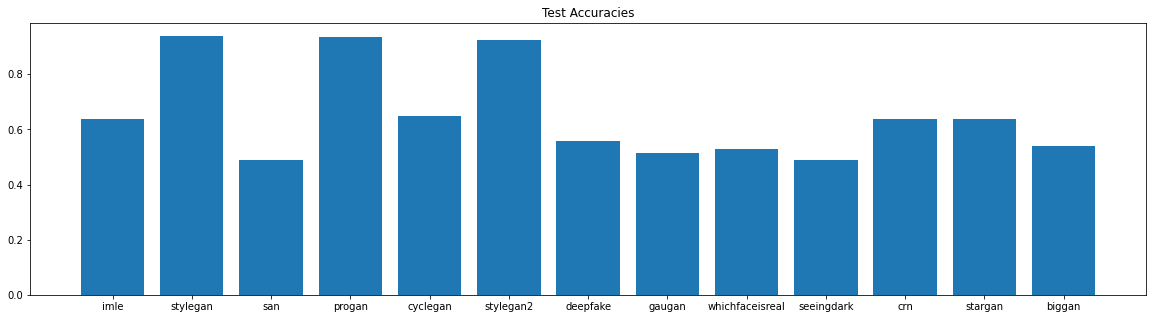

In [31]:
plt.figure(figsize=(20,5))
plt.title("Test Accuracies")
plt.bar(gans, test_accs)